In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import regularizers
import tensorflow as tf
import sklearn

In [2]:
# 输出当前使用的库版本
print("NumPy 版本:", np.__version__)
print("Pandas 版本:", pd.__version__)
# print("Matplotlib 版本:", plt.__version__)
print("Seaborn 版本:", sns.__version__)
print("Scikit-learn 版本:", sklearn.__version__)
print("TensorFlow 版本:", tf.__version__)
# print("Keras 版本:", keras.__version__)

NumPy 版本: 1.24.3
Pandas 版本: 2.0.3
Seaborn 版本: 0.12.2
Scikit-learn 版本: 1.3.0
TensorFlow 版本: 2.13.0


In [6]:
def del_no_pump_index(df):
    """
    Deletes the rows where the pump is not running
    """
    orginal = df.shape[0]

    # 找出没有被pump的pump_index
    pump_index = df['pump_index'].unique()
    nopump_index = []
    nopump_symbol = []
    for i in pump_index:
        df_pump = df[df['pump_index'] == i]
        # 如果df_pump的列gt不存在等于1, 打印i
        if 1 not in df_pump['gt'].values:
            nopump_symbol.append(df_pump['symbol'].unique().tolist()[0])
            nopump_index.append(i)
    print('nopump_index: ', nopump_index)
    print('nopump_symbol: ', nopump_symbol)

    print('df.shape: ', df.shape)
    print(df['pump_index'].unique().shape)

    # 删除pump_index的值等于48的行
    for i in nopump_index:
        df = df.drop(df[df['pump_index'] == i].index)

    print('df_cleaned.shape: ', df.shape)
    print(df['pump_index'].unique().shape)
    now = df.shape[0]
    print('deleted: ', orginal - now)
    return df

In [7]:
def split_dataset(time_freq):
    df = pd.read_csv('before_pump/before_pump_3D_' + time_freq + '.csv', parse_dates=['date'])
    df = del_no_pump_index(df)

    # set random seed
    np.random.seed(2021)

    # train_num为训练集的数量, test_num为测试集的数量
    train_num=np.round(317*0.8) # 254
    test_num=317-train_num      # 63

    # 查看pump_index的值
    index = df['pump_index'].unique()

    # 选取index中的train_num个数作为训练集
    train_index = np.random.choice(index, int(train_num), replace=False)
    # 选取剩下的作为测试集
    test_index = np.setdiff1d(index, train_index)

    # 选取训练集, 选取测试集
    train = df[df['pump_index'].isin(train_index)]
    test = df[df['pump_index'].isin(test_index)]
    print(train.shape, test.shape)

    # 选取训练集的特征
    X_train = train.drop(['gt'], axis=1)
    y_train = train['gt']
    X_test = test.drop(['gt'], axis=1)
    y_test = test['gt']
    return X_train, y_train, X_test, y_test

In [8]:
# --------------------------------------------------------------------------------------------------
def lstm_autoencoder(X_train, y_train, X_test, y_test):
    X_train.drop(['date','pump_index','symbol'], axis=1, inplace=True)
    X_test.drop(['date','pump_index','symbol'], axis=1, inplace=True)

    # normalize
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # train normal data
    X_train_normal = X_train[y_train == 0]
    y_train_normal = y_train[y_train == 0]
    X_train = X_train_normal
    y_train = y_train_normal

    # train abnormal data
    X_train_abnormal = X_train[y_train == 1]
    y_train_abnormal = y_train[y_train == 1]

    # # concatenate normal data and abnormal data 
    # X_test = np.concatenate((X_train_abnormal, X_test), axis=0)
    # y_test = np.concatenate((y_train_abnormal, y_test), axis=0)

    # 将时间序列数据转换为适用于LSTM自编码器的输入格式
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    # 构建LSTM自编码器模型
    reg = 0.0001
    inputs = Input(shape=(X_train.shape[1],X_train.shape[2]))
    encoded = LSTM(32, activation='relu', return_sequences=True
                    , kernel_regularizer=regularizers.l2(reg)
                    )(inputs)
    encoded = LSTM(16, activation='relu', return_sequences=False)(encoded)
    decoded = RepeatVector(X_train.shape[1])(encoded)
    decoded = LSTM(16, activation='relu', return_sequences=True,)(decoded)
    decoded = LSTM(32, activation='relu', return_sequences=True)(decoded)
    outputs = TimeDistributed(Dense(X_train.shape[2]))(decoded)
    autoencoder = Model(inputs, outputs)
    autoencoder.compile(optimizer='adam', loss='mae')
    # adam = optimizers.Adam(learning_rate=0.0001)
    # autoencoder.compile(optimizer=adam, loss='mae')
    # autoencoder.summary()
    
    # 使用训练数据训练LSTM自编码器模型
    early_stopping = EarlyStopping(monitor='val_loss'
                                # , min_delta=0.0001
                                , patience=12
                                , verbose=1
                                # , mode='min'
                                , restore_best_weights=True)
    history= autoencoder.fit(X_train, X_train
                            , epochs=150
                            , batch_size=32
                            , validation_split=0.1
                            , callbacks=[early_stopping]
                            )

    # plot loss curve
    fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
    ax.plot(history.history['loss'], 'b', label='Train', linewidth=2)
    ax.plot(history.history['val_loss'], 'r', label='Validation', linewidth=2)
    ax.set_title('LSTM-AutoEncoder Model loss', fontsize=16)
    ax.set_ylabel('Loss (mae)')
    ax.set_xlabel('Epoch')
    ax.legend(loc='upper right')
    plt.show()

    # 使用训练好的LSTM自编码器重构训练数据
    X_train_pred = autoencoder.predict(X_train)
    X_train_pred = X_train_pred.reshape(X_train_pred.shape[0], X_train_pred.shape[2])
    trainX = X_train.reshape(X_train.shape[0], X_train.shape[2])

    # 计算还原误差MAE
    train_mae = np.mean(np.abs(trainX - X_train_pred), axis=1)

    # 使用训练好的LSTM自编码器重构测试数据
    X_test_pred = autoencoder.predict(X_test)
    X_test_pred = X_test_pred.reshape(X_test_pred.shape[0], X_test_pred.shape[2])
    testX = X_test.reshape(X_test.shape[0], X_test.shape[2])

    # 计算还原误差MAE
    test_mae = np.mean(np.abs(testX - X_test_pred), axis=1)

    return autoencoder, train_mae, y_train, test_mae, y_test



# --------------------------------------------------------------------------------------------------
def pick_threshold(y, preds):
    thresholds = np.linspace(0, 10, 1000)
    f1_scores = [f1_score(y, preds > t) for t in thresholds]
    precision_scores = [precision_score(y, preds > t) for t in thresholds]
    recall_scores = [recall_score(y, preds > t) for t in thresholds]
    plt.figure(figsize=(12, 6))
    plt.plot(thresholds, f1_scores, label='F1 Score')
    plt.plot(thresholds, precision_scores, label='Precision')
    plt.plot(thresholds, recall_scores, label='Recall')
    plt.axvline(x=thresholds[np.argmax(f1_scores)], color='r', linestyle='--', label='Max F1 Score')
    plt.title('F1 Score w.r.t varying threshold')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.show()
    best_threshold = thresholds[np.argmax(f1_scores)]
    print('Best threshold: ', best_threshold)
    print('Best F1 Score: ', np.max(f1_scores))
    print('Recall: ', recall_score(y, preds > best_threshold))
    print('Precision: ', precision_score(y, preds > best_threshold))
    

    cm = confusion_matrix(y, preds > best_threshold)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('LSTM-AutoEncoder - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    return best_threshold
# ------------------------------set threshold--------------------------------------------------------
def set_threshold(y_test, test_mae, threshold):
    # 设置阈值
    threshold = threshold
    print("Reconstruction error threshold: ", threshold)
    y_test_pred = np.where(test_mae >= threshold , 1, 0)

    # precision, recall, f1-score
    print('F1 score: {}'.format(f1_score(y_test, y_test_pred)))
    print('Recall: {}'.format(recall_score(y_test, y_test_pred)))
    print('Precision: {}'.format(precision_score(y_test, y_test_pred)))
    

    # plot confusion matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('LSTM-AutoEncoder - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


# LSTM AutoEncoder

- 25S

In [9]:
X_train, y_train, X_test, y_test = split_dataset('25S')

nopump_index:  []
nopump_symbol:  []
df.shape:  (86725, 16)
(317,)
df_cleaned.shape:  (86725, 16)
(317,)
deleted:  0
(70717, 16) (16008, 16)


Epoch 1/150
1982/1982 [==============================] - 9s 3ms/step - loss: 0.1660 - val_loss: 0.1183
Epoch 2/150
1982/1982 [==============================] - 5s 3ms/step - loss: 0.1005 - val_loss: 0.1137
Epoch 3/150
1982/1982 [==============================] - 5s 3ms/step - loss: 0.0643 - val_loss: 0.0552
Epoch 4/150
1982/1982 [==============================] - 5s 2ms/step - loss: 0.0451 - val_loss: 0.0488
Epoch 5/150
1982/1982 [==============================] - 5s 3ms/step - loss: 0.0427 - val_loss: 0.0451
Epoch 6/150
1982/1982 [==============================] - 5s 3ms/step - loss: 0.0415 - val_loss: 0.0432
Epoch 7/150
1982/1982 [==============================] - 5s 3ms/step - loss: 0.0408 - val_loss: 0.0448
Epoch 8/150
1982/1982 [==============================] - 5s 3ms/step - loss: 0.0404 - val_loss: 0.0456
Epoch 9/150
1982/1982 [==============================] - 5s 3ms/step - loss: 0.0399 - val_loss: 0.0423
Epoch 10/150
1982/1982 [==============================] - 5s 2ms/step - l

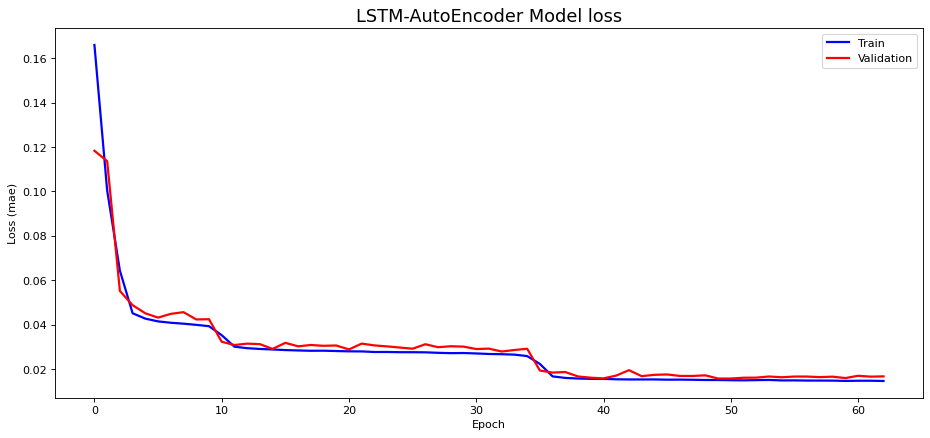

501/501 [==============================] - 1s 982us/step


In [10]:
autoencoder_25S, train_mae_25S, y_train_25S, test_mae_25S, y_test_25S = lstm_autoencoder(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

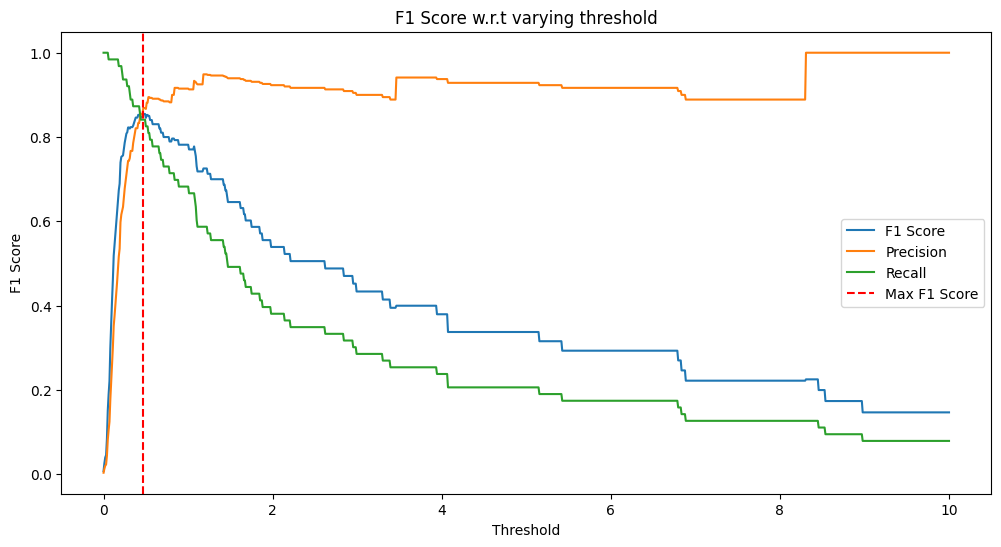

Best threshold:  0.47047047047047047
Best F1 Score:  0.8548387096774194
Recall:  0.8412698412698413
Precision:  0.8688524590163934


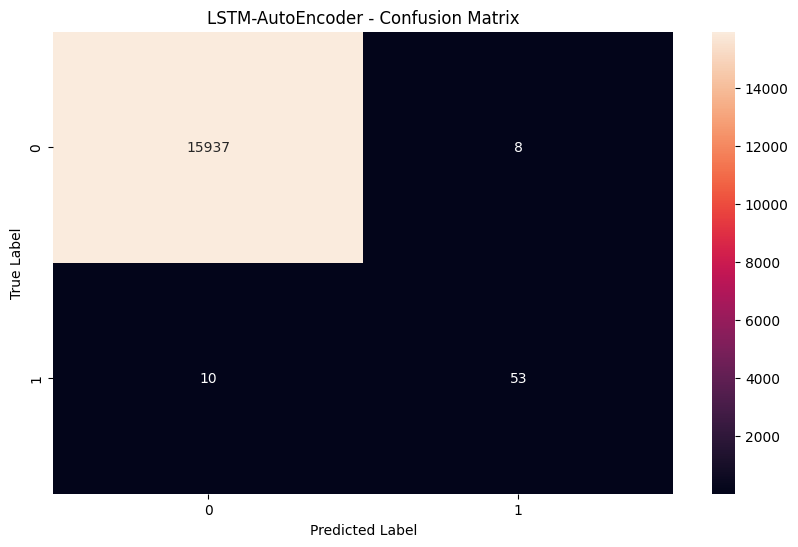

In [11]:
threshold_25S = pick_threshold(y_test_25S, test_mae_25S)

# Before and After 7 Days
# Best threshold:  1.0510510510510511
# Best F1 Score:  0.7933884297520662
# Recall:  0.7619047619047619
# Precision:  0.8275862068965517

# Before 3 Days
# Best threshold:  0.47047047047047047
# Best F1 Score:  0.8548387096774194
# Recall:  0.8412698412698413
# Precision:  0.8688524590163934

- 15S

In [12]:
X_train, y_train, X_test, y_test = split_dataset('15S')

nopump_index:  []
nopump_symbol:  []
df.shape:  (103566, 16)
(317,)
df_cleaned.shape:  (103566, 16)
(317,)
deleted:  0
(84610, 16) (18956, 16)


Epoch 1/150
2373/2373 [==============================] - 10s 3ms/step - loss: 0.1988 - val_loss: 0.0986
Epoch 2/150
2373/2373 [==============================] - 6s 3ms/step - loss: 0.0583 - val_loss: 0.0585
Epoch 3/150
2373/2373 [==============================] - 7s 3ms/step - loss: 0.0531 - val_loss: 0.0580
Epoch 4/150
2373/2373 [==============================] - 6s 3ms/step - loss: 0.0522 - val_loss: 0.0566
Epoch 5/150
2373/2373 [==============================] - 6s 3ms/step - loss: 0.0518 - val_loss: 0.0559
Epoch 6/150
2373/2373 [==============================] - 7s 3ms/step - loss: 0.0514 - val_loss: 0.0555
Epoch 7/150
2373/2373 [==============================] - 6s 3ms/step - loss: 0.0510 - val_loss: 0.0562
Epoch 8/150
2373/2373 [==============================] - 6s 3ms/step - loss: 0.0477 - val_loss: 0.0400
Epoch 9/150
2373/2373 [==============================] - 6s 2ms/step - loss: 0.0358 - val_loss: 0.0382
Epoch 10/150
2373/2373 [==============================] - 6s 3ms/step - 

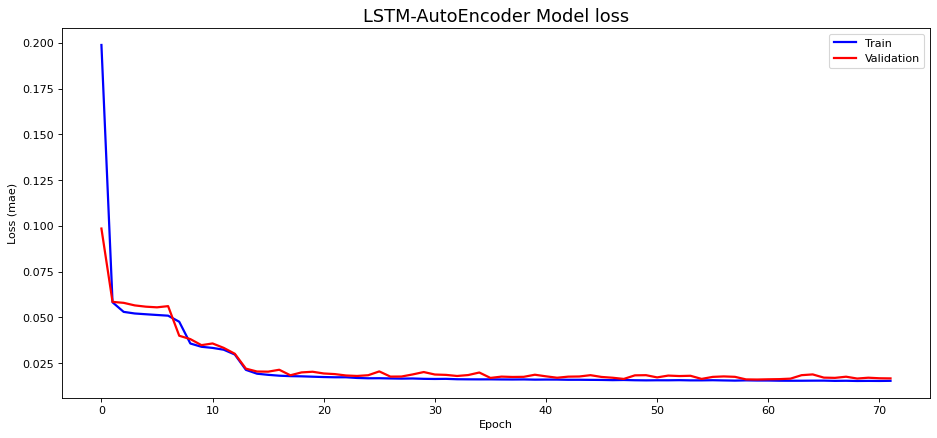

593/593 [==============================] - 1s 983us/step


In [13]:
autoencoder_15S, train_mae_15S, y_train_15S, test_mae_15S, y_test_15S = lstm_autoencoder(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

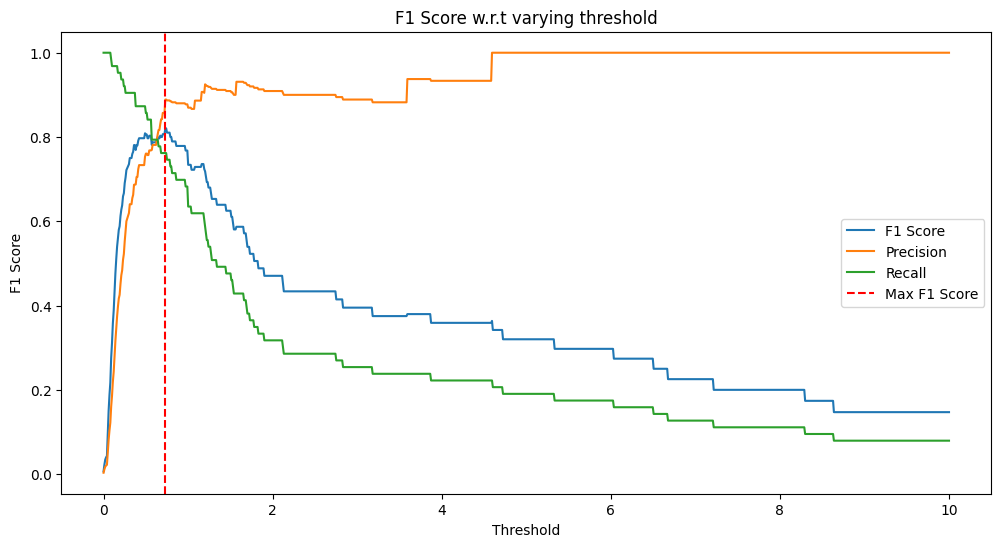

Best threshold:  0.7307307307307307
Best F1 Score:  0.8205128205128205
Recall:  0.7619047619047619
Precision:  0.8888888888888888


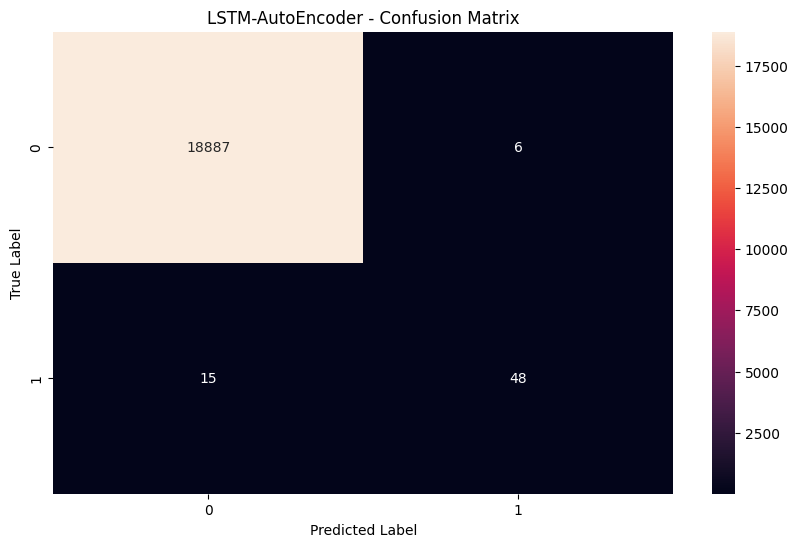

In [14]:
threshold_15S = pick_threshold(y_test_15S, test_mae_15S)

# Before and After 7 Days
# Best threshold:  1.1711711711711712
# Best F1 Score:  0.768
# Recall:  0.7619047619047619
# Precision:  0.7741935483870968

# Before 3 Days
# Best threshold:  0.7307307307307307
# Best F1 Score:  0.8205128205128205
# Recall:  0.7619047619047619
# Precision:  0.8888888888888888

- 5S

In [15]:
X_train, y_train, X_test, y_test = split_dataset('5S')

nopump_index:  []
nopump_symbol:  []
df.shape:  (144252, 16)
(317,)
df_cleaned.shape:  (144252, 16)
(317,)
deleted:  0
(117534, 16) (26718, 16)


Epoch 1/150
3299/3299 [==============================] - 13s 3ms/step - loss: 0.2043 - val_loss: 0.1643
Epoch 2/150
3299/3299 [==============================] - 8s 3ms/step - loss: 0.1408 - val_loss: 0.1624
Epoch 3/150
3299/3299 [==============================] - 8s 3ms/step - loss: 0.1323 - val_loss: 0.0835
Epoch 4/150
3299/3299 [==============================] - 8s 2ms/step - loss: 0.0726 - val_loss: 0.0722
Epoch 5/150
3299/3299 [==============================] - 8s 3ms/step - loss: 0.0706 - val_loss: 0.0710
Epoch 6/150
3299/3299 [==============================] - 9s 3ms/step - loss: 0.0697 - val_loss: 0.0688
Epoch 7/150
3299/3299 [==============================] - 8s 2ms/step - loss: 0.0587 - val_loss: 0.0544
Epoch 8/150
3299/3299 [==============================] - 8s 3ms/step - loss: 0.0524 - val_loss: 0.0527
Epoch 9/150
3299/3299 [==============================] - 8s 3ms/step - loss: 0.0515 - val_loss: 0.0510
Epoch 10/150
3299/3299 [==============================] - 8s 2ms/step - 

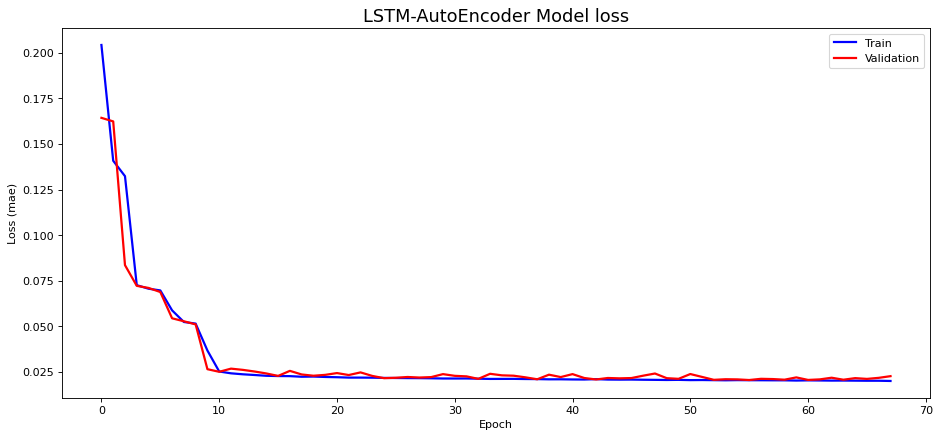

835/835 [==============================] - 1s 995us/step


In [16]:
autoencoder_5S, train_mae_5S, y_train_5S, test_mae_5S, y_test_5S = lstm_autoencoder(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

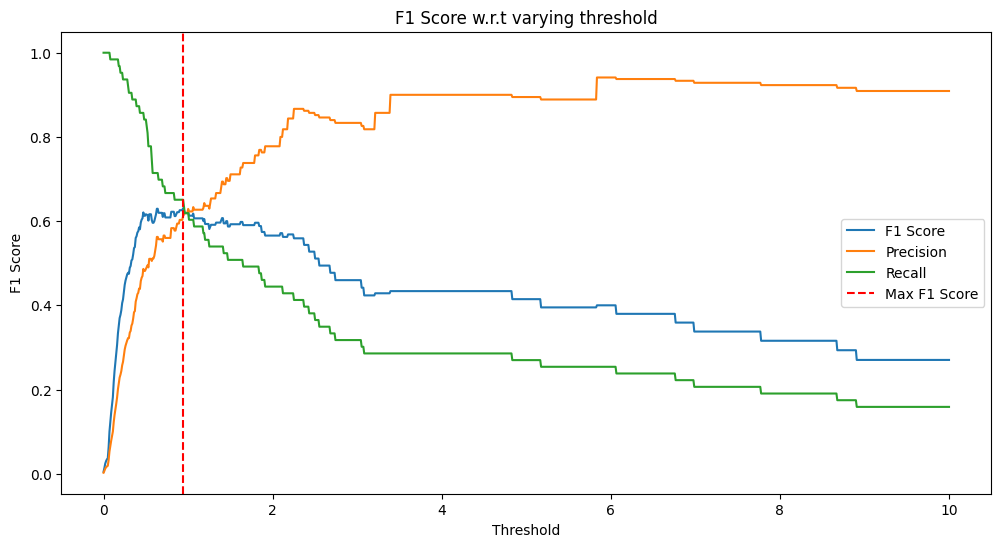

Best threshold:  0.9409409409409409
Best F1 Score:  0.6307692307692307
Recall:  0.6507936507936508
Precision:  0.6119402985074627


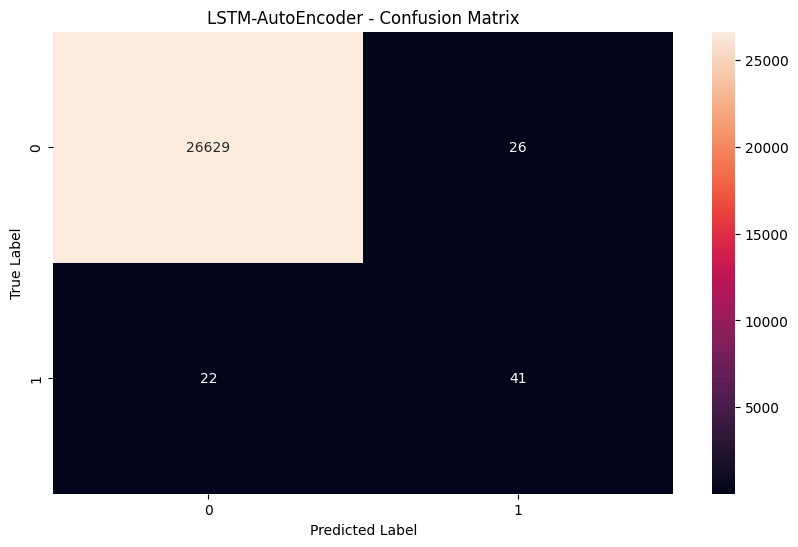

In [17]:
threshold_5S = pick_threshold(y_test_5S, test_mae_5S)

# Before and After 7 Days
# Best threshold:  1.8518518518518519
# Best F1 Score:  0.5961538461538461
# Recall:  0.49206349206349204
# Precision:  0.7560975609756098

# Before 3 Days
# Best threshold:  0.9409409409409409
# Best F1 Score:  0.6307692307692307
# Recall:  0.6507936507936508
# Precision:  0.6119402985074627

Reconstruction error threshold_5S:  0.9409409409409409
Reconstruction error threshold_15S:  0.7307307307307307
Reconstruction error threshold_25S:  0.47047047047047047
5S: F1 Score: 0.6307692307692307, Recall: 0.6507936507936508, Precision: 0.6119402985074627
15S: F1 Score: 0.8205128205128205, Recall: 0.7619047619047619, Precision: 0.8888888888888888
25S: F1 Score: 0.8548387096774194, Recall: 0.8412698412698413, Precision: 0.8688524590163934


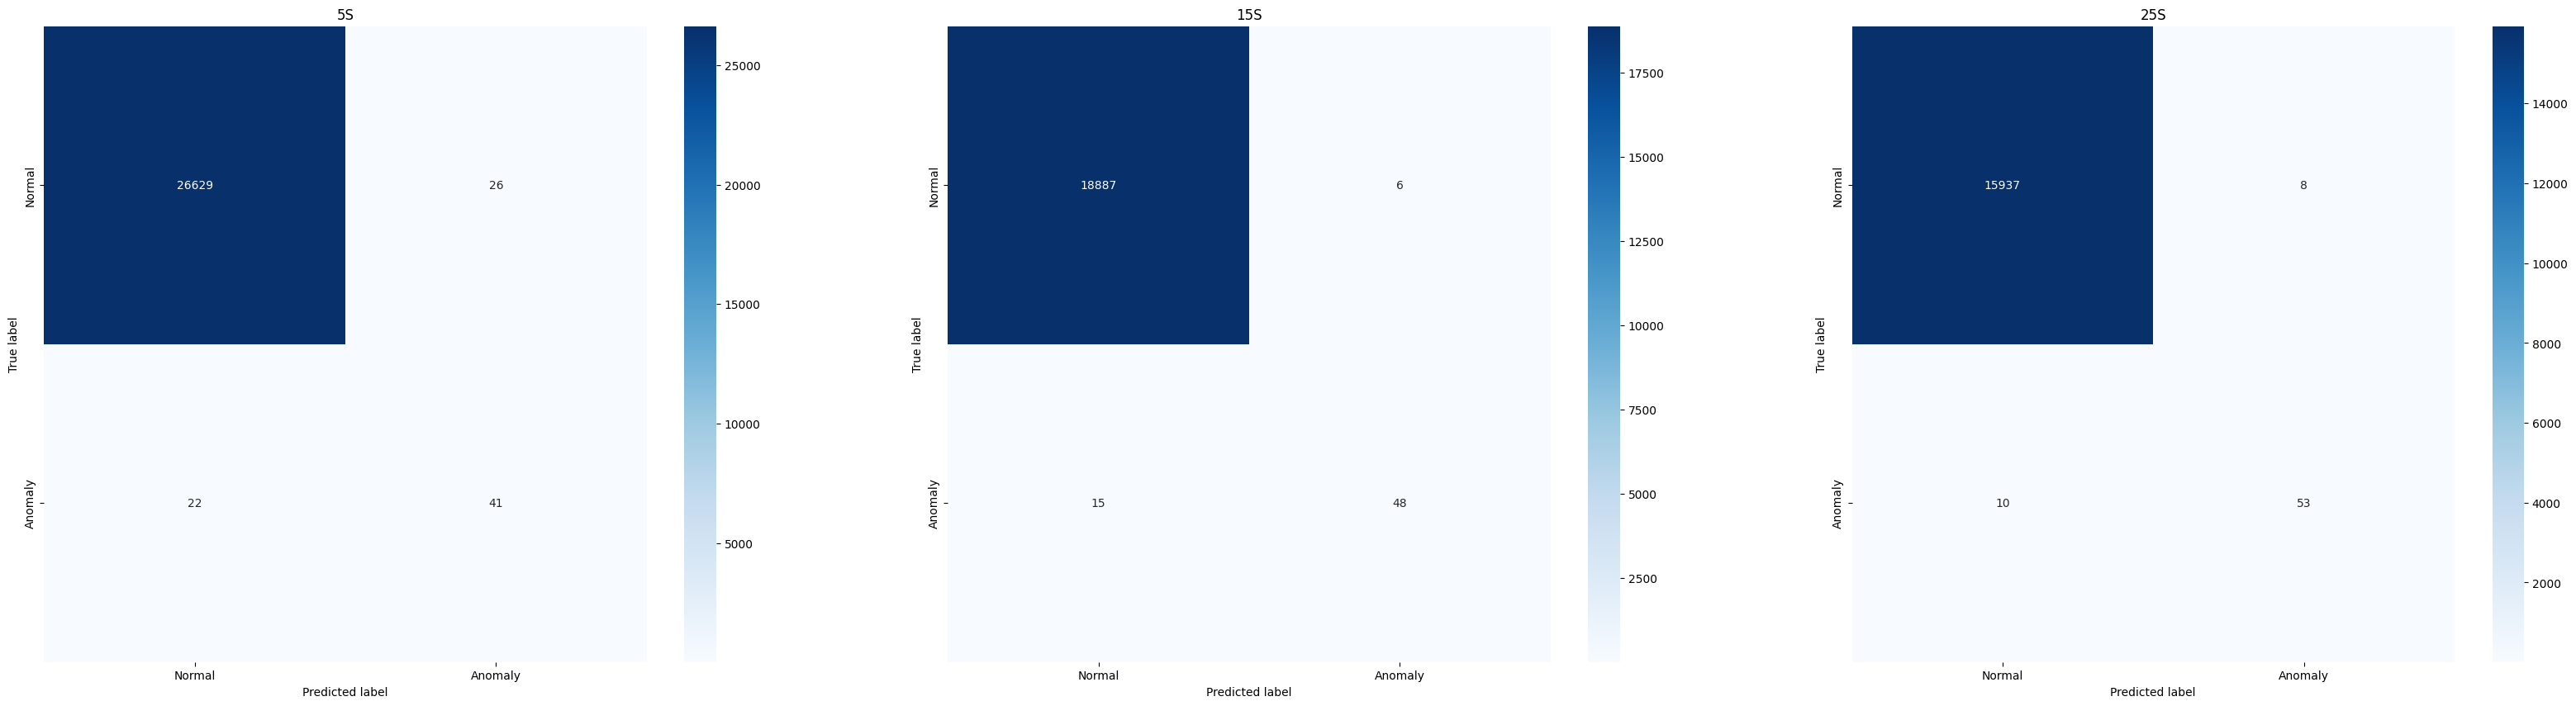

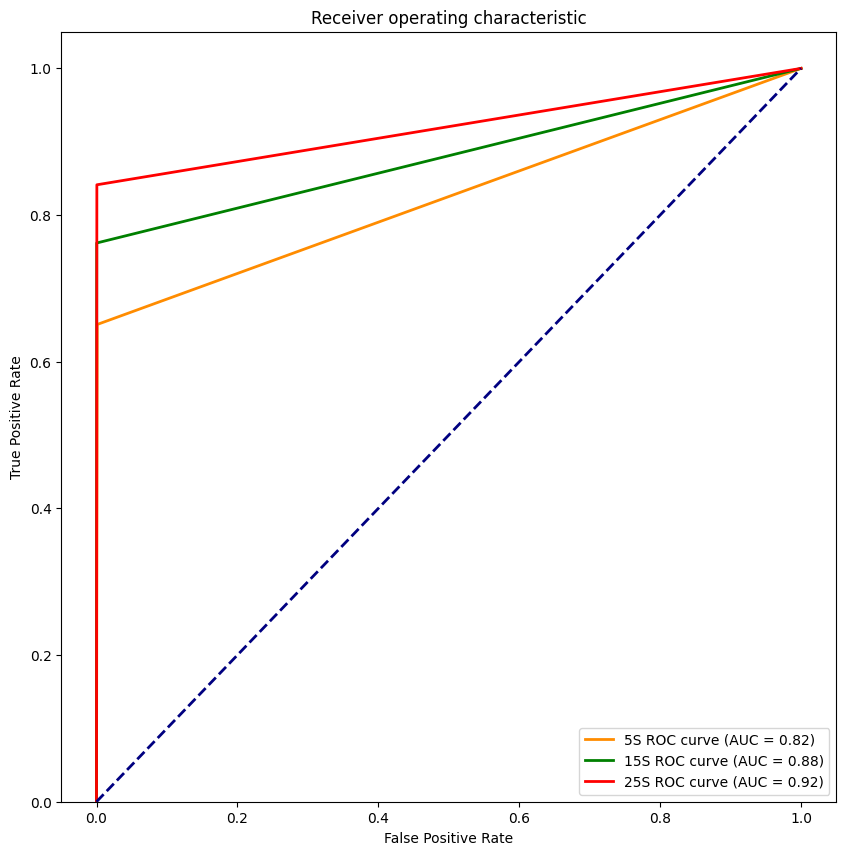

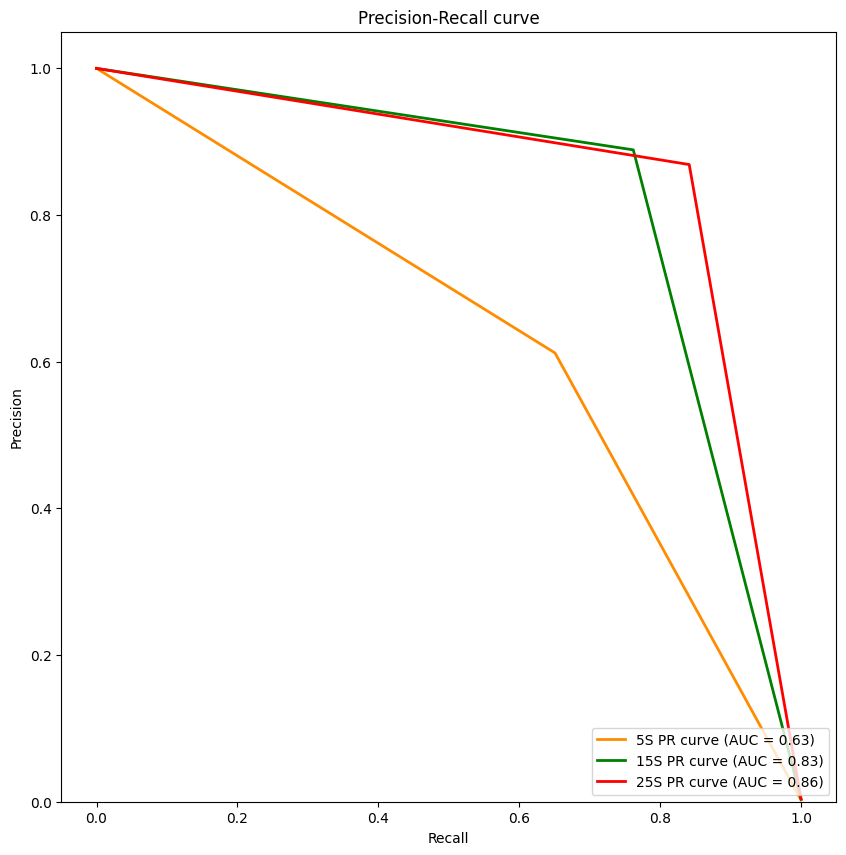

In [18]:
# 设置阈值
print("Reconstruction error threshold_5S: ", threshold_5S)
print("Reconstruction error threshold_15S: ", threshold_15S)
print("Reconstruction error threshold_25S: ", threshold_25S)

y_test_pred_5S = np.where(test_mae_5S >= threshold_5S , 1, 0)
y_test_pred_15S = np.where(test_mae_15S >= threshold_15S , 1, 0)
y_test_pred_25S = np.where(test_mae_25S >= threshold_25S , 1, 0)

# Sigmoid 函数
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

y_test_prod_5S = sigmoid(y_test_pred_5S)
y_test_prod_15S = sigmoid(y_test_pred_15S)
y_test_prod_25S = sigmoid(y_test_pred_25S)

# precision, recall, f1-score
from sklearn.metrics import f1_score, recall_score, precision_score
F1_score_5S = f1_score(y_test_5S, y_test_pred_5S)
Recall_5S = recall_score(y_test_5S, y_test_pred_5S)
Precision_5S = precision_score(y_test_5S, y_test_pred_5S)

F1_score_15S = f1_score(y_test_15S, y_test_pred_15S)
Recall_15S = recall_score(y_test_15S, y_test_pred_15S)
Precision_15S = precision_score(y_test_15S, y_test_pred_15S)

F1_score_25S = f1_score(y_test_25S, y_test_pred_25S)
Recall_25S = recall_score(y_test_25S, y_test_pred_25S)
Precision_25S = precision_score(y_test_25S, y_test_pred_25S)

print('5S: F1 Score: {}, Recall: {}, Precision: {}'.format(F1_score_5S, Recall_5S, Precision_5S))
print('15S: F1 Score: {}, Recall: {}, Precision: {}'.format(F1_score_15S, Recall_15S, Precision_15S))
print('25S: F1 Score: {}, Recall: {}, Precision: {}'.format(F1_score_25S, Recall_25S, Precision_25S))

# plot confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix_5S = confusion_matrix(y_test_5S, y_test_pred_5S)
confusion_matrix_15S = confusion_matrix(y_test_15S, y_test_pred_15S)
confusion_matrix_25S = confusion_matrix(y_test_25S, y_test_pred_25S)

plt.figure(figsize=(40,10))
plt.subplot(1,3,1)
plt.title('5S')
sns.heatmap(confusion_matrix_5S, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.subplot(1,3,2)
plt.title('15S')
sns.heatmap(confusion_matrix_15S, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.subplot(1,3,3)
plt.title('25S')
sns.heatmap(confusion_matrix_25S, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted label')
plt.ylabel('True label')


# plot ROC curve
from sklearn.metrics import roc_curve, auc
# fpr_5S, tpr_5S, thresholds_5S = roc_curve(y_test_5S, y_test_pred_5S)
fpr_5S, tpr_5S, thresholds_5S = roc_curve(y_test_5S, y_test_prod_5S)
roc_auc_5S = auc(fpr_5S, tpr_5S)


# fpr_15S, tpr_15S, thresholds_15S = roc_curve(y_test_15S, y_test_pred_15S)
fpr_15S, tpr_15S, thresholds_15S = roc_curve(y_test_15S, y_test_prod_15S)
roc_auc_15S = auc(fpr_15S, tpr_15S)

# fpr_25S, tpr_25S, thresholds_25S = roc_curve(y_test_25S, y_test_pred_25S)
fpr_25S, tpr_25S, thresholds_25S = roc_curve(y_test_25S, y_test_prod_25S)
roc_auc_25S = auc(fpr_25S, tpr_25S)

plt.figure(figsize=(10,10))
plt.plot(fpr_5S, tpr_5S, color='darkorange', lw=2, label='5S ROC curve (AUC = %0.2f)' % roc_auc_5S) # lw: line width
plt.plot(fpr_15S, tpr_15S, color='green', lw=2, label='15S ROC curve (AUC = %0.2f)' % roc_auc_15S) # lw: line width
plt.plot(fpr_25S, tpr_25S, color='red', lw=2, label='25S ROC curve (AUC = %0.2f)' % roc_auc_25S) # lw: line width
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # 画对角线
# plt.xlim([0.0, 1.0]) # x轴范围
plt.ylim([0.0, 1.05]) # y轴范围
plt.xlabel('False Positive Rate') # x轴标签
plt.ylabel('True Positive Rate') # y轴标签
plt.title('Receiver operating characteristic') # 图片标题
plt.legend(loc="lower right") # 图例
plt.show()


# plot PR curve
from sklearn.metrics import precision_recall_curve
# precision_5S, recall_5S, thresholds_5S = precision_recall_curve(y_test_5S, y_test_pred_5S)
# precision_15S, recall_15S, thresholds_15S = precision_recall_curve(y_test_15S, y_test_pred_15S)
# precision_25S, recall_25S, thresholds_25S = precision_recall_curve(y_test_25S, y_test_pred_25S)

precision_5S, recall_5S, thresholds_5S = precision_recall_curve(y_test_5S, y_test_prod_5S)
precision_15S, recall_15S, thresholds_15S = precision_recall_curve(y_test_15S, y_test_prod_15S)
precision_25S, recall_25S, thresholds_25S = precision_recall_curve(y_test_25S, y_test_prod_25S)

plt.figure(figsize=(10,10))
plt.plot(recall_5S, precision_5S, color='darkorange', lw=2, label='5S PR curve (AUC = %0.2f)' % auc(recall_5S, precision_5S)) # lw: line width
plt.plot(recall_15S, precision_15S, color='green', lw=2, label='15S PR curve (AUC = %0.2f)' % auc(recall_15S, precision_15S)) # lw: line width
plt.plot(recall_25S, precision_25S, color='red', lw=2, label='25S PR curve (AUC = %0.2f)' % auc(recall_25S, precision_25S)) # lw: line width
# plt.xlim([0.0, 1.0]) # x轴范围
plt.ylim([0.0, 1.05]) # y轴范围
plt.xlabel('Recall') # x轴标签
plt.ylabel('Precision') # y轴标签
plt.title('Precision-Recall curve') # 图片标题
plt.legend(loc="lower right") # 图例
plt.show()


# Before After Pump 7D
# Reconstruction error threshold_5S:  1.8518518518518519
# Reconstruction error threshold_15S:  1.1711711711711712
# Reconstruction error threshold_25S:  1.0510510510510511
# 5S: F1 Score: 0.5961538461538461, Recall: 0.49206349206349204, Precision: 0.7560975609756098
# 15S: F1 Score: 0.768, Recall: 0.7619047619047619, Precision: 0.7741935483870968
# 25S: F1 Score: 0.7933884297520662, Recall: 0.7619047619047619, Precision: 0.8275862068965517

# Before Pump 3D
# Reconstruction error threshold_5S:  0.9409409409409409
# Reconstruction error threshold_15S:  0.7307307307307307
# Reconstruction error threshold_25S:  0.47047047047047047
# 5S: F1 Score: 0.6307692307692307, Recall: 0.6507936507936508, Precision: 0.6119402985074627
# 15S: F1 Score: 0.8205128205128205, Recall: 0.7619047619047619, Precision: 0.8888888888888888
# 25S: F1 Score: 0.8548387096774194, Recall: 0.8412698412698413, Precision: 0.8688524590163934



In [ ]:
# threshold = threshold_5S
# set_threshold(y_test_5S, test_mae_5S, threshold_5S)

In [45]:
# # 设置阈值
# threshold_1 = np.mean(test_mae_loss) + 3 * np.std(test_mae_loss)
# threshold_2 = np.mean(test_mae_loss) - 3 * np.std(test_mae_loss)
# print("Reconstruction error threshold: ", threshold_1, threshold_2)
# y_test_pred = np.where((test_mae_loss >= threshold_1) | (test_mae_loss< threshold_2) , 1, 0)

# # precision, recall, f1-score
# print('Recall: {}'.format(recall_score(y_test, y_test_pred)))
# print('Precision: {}'.format(precision_score(y_test, y_test_pred)))
# print('F1 score: {}'.format(f1_score(y_test, y_test_pred)))

# # plot confusion matrix
# from sklearn.metrics import confusion_matrix
# cm = confusion_matrix(y_test, y_test_pred)
# plt.figure(figsize=(10, 6))
# sns.heatmap(cm, annot=True, fmt='d')
# plt.title('LSTM-AutoEncoder - Confusion Matrix')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.show()